# Threat Hunting in OKTA

## IMPORTS

In [2]:
import pandas as pd
from datetime import datetime, timedelta
from IPython.display import Image
from datetime import datetime, timedelta
import pytz
import matplotlib.pyplot as plt
import community.community_louvain
import networkx as nx
from matplotlib.pyplot import figure
Image(filename='OKTA.png') 

ModuleNotFoundError: No module named 'community'

## Introduction to OKTA

OKTA is a cloud-based identity and access management (IAM) platform that allows organizations to securely manage user identities and access to various applications and resources. OKTA provides single sign-on (SSO), multi-factor authentication (MFA), user provisioning, and other IAM capabilities to enhance security and streamline access management processes

### System Log API
The Okta System Log records system events that are related to your organization in order to provide an audit trail that can be used to understand platform activity and to diagnose problems. The Okta System Log API provides near real-time, read-only access to your organization's system log

Common use cases for the System Log API:

 - Ingesting events into a SIEM platform for security analysis and correlation with other relevant security events
 - Ingesting events into a data warehouse or data lake for user activity analysis or complex security detections
 - Ingesting events into an observability system for application monitoring and debugging
 - As a source for customer business logic to react to events asynchronously, such as a periodic collection of new user IDs when self-service registration is enabled

    Note: The System Log API isn't intended for use as a Database as a Service (DBaaS) or to serve data directly to downstream consumers without an intermediate data store

### LogEvent Attributes

| Property              | Description                                     | DataType       | Nullable | Unique | Readonly | MinLength | MaxLength |
|-----------------------|-------------------------------------------------|----------------|----------|--------|----------|-----------|-----------|
| uuid                  | Unique identifier for an individual event       | String         | FALSE    | TRUE   | TRUE     |           |           |
| published             | Timestamp when the event is published           | Date           | FALSE    | FALSE  | TRUE     | 1         | 255       |
| eventType             | Type of [event](https://developer.okta.com/docs/reference/api/event-types/) that is published                | String         | FALSE    | FALSE  | TRUE     | 1         | 255       |
| version               | Versioning indicator                            | String         | FALSE    | FALSE  | TRUE     | 1         | 255       |
| severity              | Indicates how severe the event is               | String         | FALSE    | FALSE  | TRUE     | 1         | 255       |
| legacyEventType       | Associated Events API Action objectType attribute value | String   | TRUE     | FALSE  | TRUE     | 1         | 255       |
| displayMessage        | The display message for an event                | String         | TRUE     | FALSE  | TRUE     | 1         | 255       |
| actor                 | Describes the entity that performs an action    | Actor object   | TRUE     | FALSE  | TRUE     |           |           |
| client                | The client that requests an action              | Client object  | TRUE     | FALSE  | TRUE     |           |           |
| request               | The request that initiates an action            | Request object | TRUE     | FALSE  | TRUE     |           |           |
| outcome               | The outcome of an action                        | Outcome object | TRUE     | FALSE  | TRUE     |           |           |
| target                | Zero or more targets of an action               | Array of Target object | TRUE | FALSE  | TRUE     |           |           |
| transaction           | The transaction details of an action             | Transaction object | TRUE  | FALSE  | TRUE     |           |           |
| debugContext          | The debug request data of an action             | DebugContext object | TRUE  | FALSE  | TRUE     |           |           |
| authenticationContext | The authentication data of an action            | AuthenticationContext object | TRUE | FALSE | TRUE |        |           |
| securityContext       | The security data of an action                  | SecurityContext object | TRUE | FALSE | TRUE |        |           |


### Example LogEvent Object

## User Account Hijack

In [32]:
%%time

#%load_ext cudf.pandas --> pandas API is now GPU accelerated
#import modin.pandas as pd --> modin.pandas DataFrame is an extremely light-weight parallel DataFrame

df = pd.read_csv("./convertcsv.csv")
df.columns, df.shape

CPU times: total: 31.2 ms
Wall time: 16 ms


(Index(['severity', 'eventType', 'uuid', 'version', 'timestamp',
        'outcome.result', 'outcome.reason', 'actor.id', 'actor.type',
        'actor.display_name', 'actor.alternate_id', 'client.ip_address',
        'client.geographical_context.country',
        'client.geographical_context.city',
        'client.geographical_context.postal_code',
        'client.geographical_context.geolocation.lon',
        'client.geographical_context.geolocation.lat', 'transaction.id',
        'transaction.type'],
       dtype='object'),
 (13, 19))

In [30]:
import pandas as pd

# Convert datetime.now() to UTC
df['timestamp'] = pd.to_datetime(df['timestamp'])
now_utc = datetime.now(pytz.utc)

# Filter for events
filtered_df = df[
    (df['eventType'].isin(['user.mfa.factor.activate', 'user.mfa.factor.deactivate', 'user.account.reset_password', 'user.session.start', 'device.user.add'])) &
    (df['outcome.result'] == 'SUCCESS')
    #(df['@timestamp'] > (now_utc - timedelta(weeks=1)))
]

# Apply aggregations-
result_df = filtered_df.groupby(["client.ip_address", "client.geographical_context.country", "actor.alternate_id"]).agg(
    first_event=pd.NamedAgg(column='timestamp', aggfunc='min'),
    last_event=pd.NamedAgg(column='timestamp', aggfunc='max'),
    unique_events=pd.NamedAgg(column='eventType', aggfunc='nunique'),  # nunique() is for unique values
    event_count=pd.NamedAgg(column='timestamp', aggfunc='size'),  # size() is for counting rows
    events=pd.NamedAgg(column='eventType', aggfunc=lambda x: list(set(x))),
    duration_epoch=pd.NamedAgg(column='timestamp', aggfunc=lambda x: (x.max() - x.min()).total_seconds())
).reset_index()

# Apply Threshold depending on your environment
result_df = result_df[result_df['unique_events'] >= 2]
result_df

,client.ip_address,client.geographical_context.country,actor.alternate_id,first_event,last_event,unique_events,event_count,events,duration_epoch
1,192.168.1.2,USA,john.doe,2024-03-15 08:10:01,2024-03-15 08:10:02,2,2,"[user.session.start, user.mfa.factor.activate]",1.0


## Password Spray

In [33]:
filtered_df = df[
    (df['eventType'].isin(['security.threat.detected'])) & 
    (df['outcome.reason'] == 'Password Spray')]
filtered_df.shape

(8, 19)

In [40]:
result_df = filtered_df[['timestamp', 'eventType',  'client.geographical_context.country', 'outcome.result', 'outcome.reason', 'actor.alternate_id', 'client.ip_address']]

# Drop duplicates based on the 'client.ipAddress' column
result_df = result_df.drop_duplicates(subset=['client.ip_address'])
result_df.reset_index(drop=True, inplace=True)

result_df

,timestamp,eventType,client.geographical_context.country,outcome.result,outcome.reason,actor.alternate_id,client.ip_address
0,2024-03,security.threat.detected,USA,SUCCESS,Password Spray,jik,192.234.5.6


## Suspicious Tenant Takeover

In [ ]:
%%time

df = pd.read_csv("./OKTA_Logs_3.csv")
df.shape

In [ ]:
# Filter for events
filtered_df = df[
    (df['eventType'].isin(['user.lifecycle.deactivate', 'user.lifecycle.suspend'])) &
    (df['outcome.result'] == 'SUCCESS')
]

# Apply aggregations
result_df = filtered_df.groupby(["client.ipAddress", "client.geographicalContext.country", "actor.alternateId"]).agg(
    first_event=pd.NamedAgg(column='@timestamp', aggfunc='min'),
    last_event=pd.NamedAgg(column='@timestamp', aggfunc='max'),
    unique_suspended_users=('TargetalternateId', lambda x: x[df["eventType"] == 'user.lifecycle.suspend'].nunique()),
    unique_deactivated_users=('TargetalternateId', lambda x: x[df["eventType"] == 'user.lifecycle.deactivate'].nunique())
).reset_index()

# Apply Threshold depending on your environment
result_df = result_df[
    (result_df['unique_suspended_users'] >= 1) | (result_df['unique_deactivated_users'] >= 1)
]

result_df

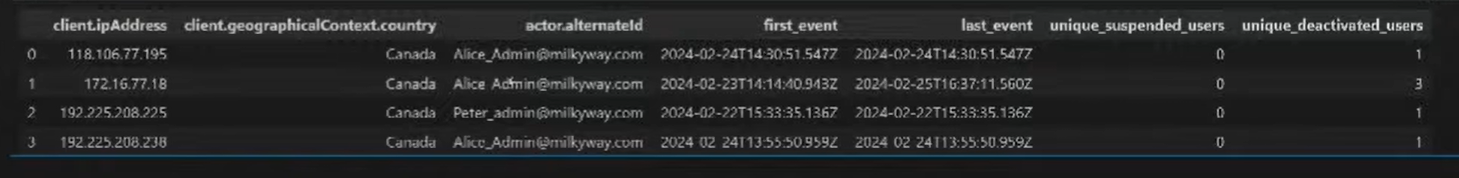

## Admin Privileges Revoked

In [ ]:
%%time

df = pd.read_csv("./OKTA_Logs_2.csv")
df.shape

In [ ]:
# Extract 'alternateId' from the dictionary within 'target' column
    
df['target'] = df['target'].apply(literal_eval)
df['TargetalternateId'] = df['target'].apply(lambda x: x[0]['alternateId'] if x else None)
df['TargetalternateId'][0]

In [ ]:
filtered_df = df[
    (df['eventType'].isin(['user.account.privilege.revoke', 'group.privilege.revoke'])) &
    (df['outcome.result'] == 'SUCCESS')
]

# Apply aggregations    
result_df = filtered_df.groupby(["actor.alternateId"]).agg(
    first_event=pd.NamedAgg(column='@timestamp', aggfunc='min'),
    last_event=pd.NamedAgg(column='@timestamp', aggfunc='max'),
    revoked_users=('TargetalternateId', lambda x: (x[df["eventType"] == 'user.account.privilege.revoke'].nunique())),
    revoked_groups=('TargetalternateId', lambda x: (x[df["eventType"] == 'group.account.privilege.revoke'].nunique()))
).reset_index()

# Apply Threshold depending on your environment
result_df = result_df[
    (result_df['revoked_users'] > 1) | (result_df['revoked_groups'] > 1)
]

result_df

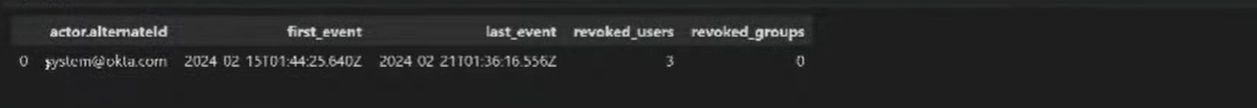

## OKTA ThreatInsight Alerts

In [ ]:
%%time

df = pd.read_csv("./OKTA_Logs_4.csv")
df.shape

In [ ]:
df.columns

In [ ]:

# Filter the DataFrame based on eventType condition
filtered_df = df[df['eventType'] == 'security.threat.detected']

# Group by fields and aggregate
result_df = filtered_df.groupby(["actor.displayName", "actor.type", "actor.alternateId", "eventType", "debugContext.debugData.threatDetections"]).agg(
    first_event=('@timestamp', 'min'),
    last_event=('@timestamp', 'max')
).reset_index()

result_df

## Session Hijacking

In [ ]:
%%time

df = pd.read_csv("./OKTA_Logs_5.csv")
df.shape

In [ ]:

filtered_df = df[
    (df['eventType'] == 'user.session.start') & 
    (df['outcome.result'].isin(['ALLOW', 'SUCCESS']))
]

# Filter the DataFrame based on the condition dtHash is not null
filtered_df = df[df['debugContext.debugData.dtHash'].notnull()]

# Group by actorAlternateId and dtHash, and aggregate
result_df = filtered_df.groupby(["actor.alternateId", "debugContext.debugData.dtHash"]).agg(
    unique_client_countries=('client.geographicalContext.country', 'nunique')
)

# Filter based on the condition count of distinct clientCountry > 1
result_df = result_df[result_df['unique_client_countries'] > 1]

result_df

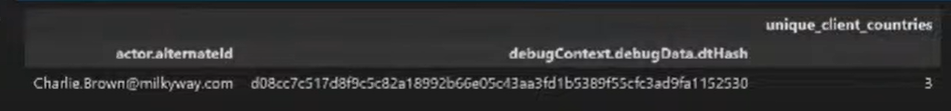

In [ ]:

# Filter the DataFrame based on eventType condition
filtered_df = df[
    (df['eventType'] == 'policy.evaluate_sign_on') & 
    (df['outcome.result'].isin(['ALLOW', 'SUCCESS']))
]

# Perform aggregation using pandas
result_df = filtered_df.groupby(['debugContext.debugData.dtHash', 'actor.alternateId']).agg(
    earliest_time=('time', 'min'),
    src_ip=('client.ipAddress', lambda x: ','.join(x.unique())),
    userAgent=('client.userAgent.rawUserAgent', lambda x: ','.join(x.unique())),
    userAgentOS_list=('client.userAgent.os', lambda x: ','.join(x.unique())),
    userAgentBrowser_list=('client.userAgent.browser', lambda x: ','.join(x.unique())),
    okta_device_os=('device.os_platform', 'first'),
    dc_userAgentBrowser=('client.userAgent.browser', 'nunique'),
    dc_userAgentOS=('client.userAgent.os', 'nunique'),
    dc_src_ip=('client.ipAddress', 'nunique'),
    reason=('outcome.reason', 'first')
).reset_index()

# Rename columns if needed
result_df.columns = ['dtHash', 'actor.alternateId', 'earliest_time', 'src_ip', 'userAgent', 'userAgentOS_list', 
                     'userAgentBrowser_list', 'okta_device_os', 'dc_userAgentBrowser', 'dc_userAgentOS', 
                     'dc_src_ip', 'reason']

# Print or use result_df as needed
print(result_df)


## OKTA Session Impersonation

In [ ]:

# Filter the DataFrame based on eventType condition
filtered_df = df[
    (df['eventType'].isin([
        "user.session.impersonation.initiate",
        "user.session.impersonation.grant",
        "user.session.impersonation.extend",
        "user.session.impersonation.end",
        "user.session.impersonation.revoke"
    ]))
]

# Group by eventType and count occurrences
result_df = filtered_df.groupby('eventType').size().reset_index(name='count')

# Print or use result_df as needed
print(result_df)


## MFA Push Notifications Fatigue

In [ ]:

# Filter the DataFrame based on eventType and time condition
filtered_df = df[
    (df['eventType'] == 'system.push.send_factor_verify_push') &
    (df['time'] > pd.Timestamp.now() - pd.Timedelta(hours=X))  # Replace X with the number of hours
]

# Group by clientIpAddress and actorAlternateId, and aggregate
result_df = filtered_df.groupby(["client.ipAddres", "actor.alternateId"]).agg(
    count_id=('id', 'count'),
    firstEvent=('time', 'min'),
    lastEvent=('time', 'max')
)

# Filter based on count_id
result_df = result_df[result_df['count_id'] >= 5]  # configurable number of MFA attempts

# Sort the DataFrame by count_id in descending order
result_df = result_df.sort_values(by='count_id', ascending=False)

result_df


## OKTA Policy Manipulation

In [ ]:

df['target'] = df['target'].apply(literal_eval)
df['targetAlternateId'] = df['target'].apply(lambda x: x[0]['alternateId'] if x else None)

# Filter the DataFrame based on eventType condition and actionResult
filtered_df = df[
    (df['eventType'].isin(['policy.lifecycle.delete', 'policy.lifecycle.update', 'policy.lifecycle.deactivate', 'policy.rule.delete', 'policy.rule.update', 'policy.rule.deactivate'])) &
    (df['actionResult'] == 'SUCCESS')
]


# Group by clientIpAddress, clientCountry, actorAlternateId, and aggregate
result_df = merged_df.groupby(['client.ipAddres', 'client.geographicalContext.country', 'actor.alternateId']).agg(
    first_event=('@timestamp', 'min'),
    last_event=('@timestamp', 'max'),
    unique_policies_updated = ('targetAlternateId', lambda x: (x[merged_df['eventType'].isin(['policy.lifecycle.update', 'policy.rule.update'])].nunique())),
    unique_policy_rules_deleted = ('targetAlternateId', lambda x: (x[(merged_df['eventType'] == 'policy.rule.update') | (merged_df['eventType'] == 'policy.rule.delete')].nunique())),
    unique_policy_deactivated = ('targetAlternateId', lambda x: (x[(merged_df['eventType'] == 'policy.rule.update') | (merged_df['eventType'] == 'policy.lifecycle.deactivate')].nunique())),
    event_count=('id', 'count')
)

# Filter based on the condition "having count(id) >= 3"
result_df = result_df[result_df['event_count'] >= 3]

result_df

## OKTA Auth Policy Downgrade

In [ ]:

df['target'] = df['target'].apply(literal_eval)
df['targetAlternateId'] = df['target'].apply(lambda x: x[0]['alternateId'] if x else None)


# Filter the DataFrame based on eventType condition and actionResult
filtered_df = df[
    (df['eventType'].isin(['policy.lifecycle.update', 'policy.rule.update', 'policy.rule.add'])) &
    (df['actionResult'] == 'SUCCESS')
]

# Group by clientIpAddress, clientCountry, actorAlternateId, and aggregate
result_df = merged_df.groupby(['client.ipAddres', 'client.geographicalContext.country', 'actor.alternateId']).agg(
    first_event=('@timestamp', 'min'),
    last_event=('@timestamp', 'max'),
    unique_policies_updated=('targetAlternateId', lambda x: (x[merged_df['eventType'] == 'policy.lifecycle.update'].nunique())),
    unique_policy_rules_updated=('targetAlternateId', lambda x: (x[merged_df['eventType'] == 'policy.rule.update'].nunique())),
    unique_policy_rules_created=('targetAlternateId', lambda x: (x[merged_df['eventType'] == 'policy.rule.add'].nunique())),
    event_count=('id', 'count')
)

# Filter based on the condition "having count(id) >= 3"
result_df = result_df[result_df['event_count'] >= 3]

result_df

## OKTA API Token Manipulation

In [ ]:

df['target'] = df['target'].apply(literal_eval)
df['targetAlternateId'] = df['target'].apply(lambda x: x[0]['alternateId'] if x else None)


# Filter the DataFrame based on eventType condition and actionResult
filtered_df = df[
    (df['eventType'].isin(['system.api_token.create', 'system.api_token.update'])) &
    (df['actionResult'] == 'SUCCESS')
]

# Group by clientIpAddress, clientCountry, actorAlternateId, and aggregate
result_df = merged_df.groupby(['client.ipAddres', 'client.geographicalContext.country', 'actor.alternateId']).agg(
    first_event=('@timestamp', 'min'),
    last_event=('@timestamp', 'max'),
    unique_api_token_created=('targetAlternateId', lambda x: (x[merged_df['eventType'] == 'system.api_token.create'].nunique())),
    unique_api_token_updated=('targetAlternateId', lambda x: (x[merged_df['eventType'] == 'system.api_token.update'].nunique())),
    event_count=('id', 'count')
)

# Filter based on the threshold
result_df = result_df[result_df['event_count'] >= 5]

result_df

## OKTA Phishing Detection with FastPass

In [ ]:

# Filter the DataFrame based on the specified conditions
filtered_df = df[
    (df['eventType'] == 'user.authentication.auth_via_mfa') & 
    (df['result'] == 'FAILURE') & 
    (df['outcome.reason'] == 'FastPass declined phishing attempt')
]


result_df = filtered_df.drop_duplicates(subset=['client.ipAddress'])
result_df.reset_index(drop=True, inplace=True)

result_df

*Interesting Event Types*

 - user.mfa.attempt_bypass

 - user.session.access_admin_app

 - app.user_management.push_okta_password_update

 - application.policy.sign_on.deny_access

 - user.authentication.auth_via_richclient

*Fun Exercise*

Map these detections into MITRE ATT&CK Framework

## References

 - https://developer.okta.com/docs/reference/api/system-log/
 - https://sec.okta.com/shareddetections
 - https://help.okta.com/oie/en-us/content/topics/identity-engine/oie-get-started.htm
 - https://www.rezonate.io/blog/okta-logs-decoded-unveiling-identity-threats-through-threat-hunting/
 - https://www.rezonate.io/blog/okta-threat-hunting-auditing-okta-logs-part-2/
 - https://medium.com/threatpunter/okta-threat-hunting-tips-62dc0013d526
 - https://research.splunk.com/application/71ad47d1-d6bd-4e0a-b35c-020ad9a6959e/